In [22]:
!pip install tensorflow==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
import json
import requests

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

currency='BTC-USD'

In [24]:
csv_path = "/content/BTC-USD (1 year).csv"

In [25]:
df = pd.read_csv(csv_path)

In [26]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-05-20,36753.667969,42462.984375,35050.617188,40782.738281,40782.738281,88281943359
1,2021-05-21,40596.949219,42172.171875,33616.453125,37304.691406,37304.691406,82051616861
2,2021-05-22,37371.031250,38831.054688,35383.683594,37536.632813,37536.632813,57377273240
3,2021-05-23,37531.449219,38289.218750,31227.339844,34770.582031,34770.582031,78469274361
4,2021-05-24,34700.363281,39835.140625,34551.082031,38705.980469,38705.980469,67359584098


In [27]:
df.shape

(366, 7)

Text(0, 0.5, 'Closing Price in (USD)')

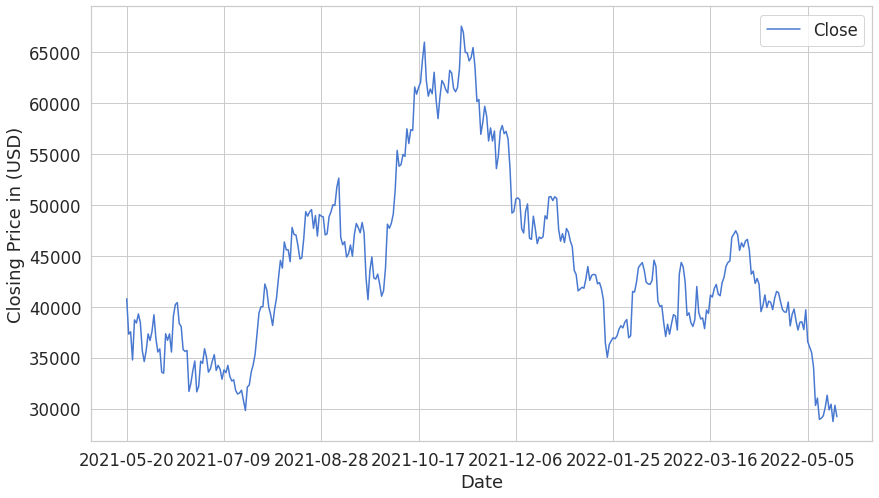

In [28]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Closing Price in (USD)")

# Normalization

In [29]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [30]:
scaled_close.shape

(366, 1)

In [31]:
np.isnan(scaled_close).any()

False

In [32]:
scaled_close = scaled_close.reshape(-1, 1)

# Preprocessing

In [33]:
SEQ_LEN = 20

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.8)

In [34]:
X_train.shape

(276, 19, 1)

In [35]:
X_test.shape

(70, 19, 1)

# Model

In [36]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [37]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [38]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.15
)

Epoch 1/100
4/4 [==============================] - 10s 651ms/step - loss: 0.1576 - val_loss: 0.0159
Epoch 2/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0374 - val_loss: 0.0136
Epoch 3/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0254 - val_loss: 0.0399
Epoch 4/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0289 - val_loss: 0.0181
Epoch 5/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0174 - val_loss: 0.0063
Epoch 6/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0218 - val_loss: 0.0051
Epoch 7/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0206 - val_loss: 0.0055
Epoch 8/100
4/4 [==============================] - 0s 30ms/step - loss: 0.0153 - val_loss: 0.0079
Epoch 9/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0132 - val_loss: 0.0102
Epoch 10/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0132 - val_loss: 0.0086
Epoch 11/100
4/4 

In [39]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 8ms/step - loss: 0.0025


0.002514614723622799

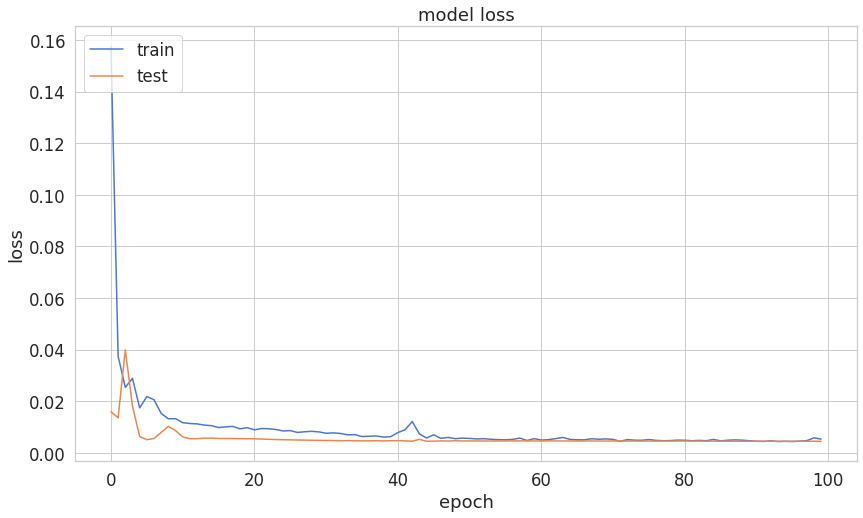

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

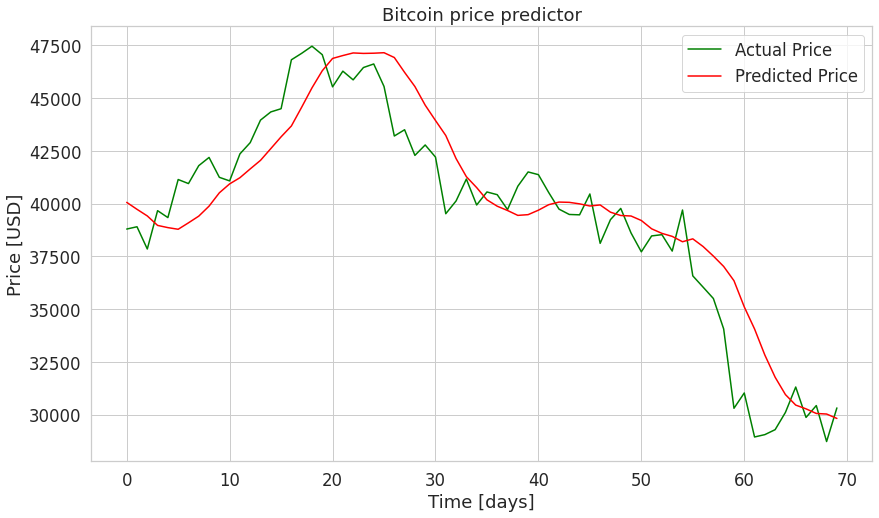

In [41]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price predictor')
plt.xlabel('Time [days]')
plt.ylabel('Price [USD]')
plt.legend(loc='best')
 
plt.show();

In [42]:
model.save("LSTM_crypto.h5")